In [1]:
from google.colab import drive
drive.mount('/PICSEL_script/')

Mounted at /PICSEL_script/


In [2]:
import ee

In [5]:
ee.Authenticate() #Apenas uma vez

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=q9Cm2LtRy6v_BgsU2kzAS2Kp92I_LVyltUFwsjRCsD4&tc=k0-6w2x8qMt8j2ImKXBAdy_6Tk2svsVAEFeXhMpCcQU&cc=d6ujBSxw6QL2miZOXKQpSHPUh7AwPe5cgeJ_2VbH38w

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AdQt8qgb-ndTXgB2eHaKjpO4donM4OiGEaEefd7urOr3UOFKnVYcz3j3RT0

Successfully saved authorization token.


In [6]:
import collections #Resolvendo uma incompatibilidade com o Windows 11
collections.Callable = collections.abc.Callable

In [7]:
ee.Initialize()

In [9]:
pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 16.3 MB/s 
     |████████████████████████████████| 130 kB 49.8 MB/s 
     |████████████████████████████████| 1.2 MB 37.5 MB/s 
     |████████████████████████████████| 98 kB 9.0 MB/s 
     |████████████████████████████████| 8.8 MB 42.9 MB/s 
     |████████████████████████████████| 3.0 MB 51.3 MB/s 
     |████████████████████████████████| 187 kB 65.4 MB/s 
     |████████████████████████████████| 1.3 MB 52.0 MB/s 
     |████████████████████████████████| 99 kB 10.7 MB/s 
     |████████████████████████████████| 3.3 MB 44.8 MB/s 
     |████████████████████████████████| 95 kB 4.7 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 128 kB 55.3 MB/s 
     |████████████████████████████████| 9.7 MB 35.7 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 

In [10]:
import geemap
Map = geemap.Map()

In [11]:
ROI_shp = '/PICSEL_script/MyDrive/Picsel_24072021/PICSEL_script/ROI.shp'
ROI = geemap.shp_to_ee(ROI_shp)

In [12]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR") #https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

In [13]:
# Função apara remover nuvens
def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask) \
      .select("B.*") \
      .copyProperties(image, ["system:time_start"])

In [14]:
filtered = s2 \
  .filter(ee.Filter.date('2020-09-01', '2021-03-31')) \
  .filter(ee.Filter.bounds(ROI)) \
  .map(maskS2clouds)

In [15]:
# Função para calcular do NDVI e acrescenta banda no conjunto de imagens da composição
def addNDVI(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return image.addBands(ndvi)

In [16]:
S2_Ndvi = filtered.map(addNDVI) #Aplicando na imagens para 

S2_composite = S2_Ndvi.median() #Imagem reduzida com a mediana do período

In [17]:
#Parametros de visualização
palette = [
  'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301']

ndviVis = {'min':0, 'max':0.5, 'palette': palette }

rgbVis = {'min': 0.0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}

In [18]:
def clip(image):
   return image.clip(ROI)

In [21]:
ROI_exp = S2_Ndvi.select('ndvi').map(clip)
ROI_exp

In [22]:
#Adicionando as camadas no mapa

#Map.addLayer(S2_Ndvi.select('B4', 'B3', 'B2'), rgbVis, 'RGB')

#Map.addLayer(S2_Ndvi.select('ndvi'), ndviVis, 'NDVI')

Map.addLayer(ROI_exp, ndviVis, 'NDVI ROI')

Map.addLayer(ROI, {}, 'ROI')

Map.centerObject(ROI, 16)
Map
# Geemap permite fazer visualizações intermediárias com o menu interativo

Map(center=[-22.048540861852157, -54.546453489519656], controls=(WidgetControl(options=['position', 'transpare…

In [25]:
from ee import geometry
#Exportar imagens
geemap.ee_export_image_collection_to_drive(ROI_exp, folder='PICSEL', scale=10, maxPixels=69335554760) 

Total number of images: 82

Unknown configuration options: {'geometry': <ee.featurecollection.FeatureCollection object at 0x7f21381eb950>}.


In [26]:
#Função para redução da coleção utilizando a média para a área ROI e associação com a data da imagem

def roi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=ROI, scale=10).get('ndvi')
    return img.set('date', img.date().format()).set('ndvi',mean)

In [27]:
ROI_reduced = S2_Ndvi.map(roi_mean)
ROI_reduced

In [28]:
# Redução da coleção de imagens em lista para converter em dataframe com data e média do NDVI

S2_Ndvi__list = ROI_reduced.reduceColumns(ee.Reducer.toList(2), ['date','ndvi']).values().get(0)
S2_Ndvi__list

In [29]:
import pandas as pd

In [30]:
# Converção em dataframe e ajuste do formato da data

df = pd.DataFrame(S2_Ndvi__list.getInfo(), columns=['date','ndvi'])
df['date'] = pd.to_datetime(df['date']).dt.strftime('%d-%m-%Y')
df = df.set_index('date')

df.head()

,ndvi
date,
02-09-2020,0.237036
07-09-2020,0.098421
10-09-2020,0.238746
12-09-2020,0.254554
15-09-2020,0.241353


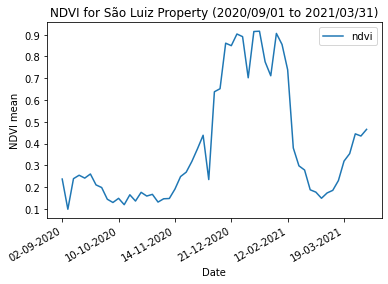

In [31]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates

ax = df.plot()

plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("NDVI mean")
plt.title('NDVI for São Luiz Property (2020/09/01 to 2021/03/31)')

plt.show()